# Prologue

For this project we will use the logistic regression function to model the growth of confirmed Covid-19 case population growth in Bangladesh. The logistic regression function is commonly used in classification problems, and in this project we will be examining how it fares as a regression tool. Both cumulative case counts over time and logistic regression curves have a sigmoid shape and we shall try to fit a theoretically predicted curve over the actual cumulative case counts over time to reach certain conclusions about the case count growth, such as the time of peak daily new cases and the total cases that may be reached during this outbreak.

# Import the necessary modules

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Connect to Google Drive (where the data is kept)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data and format as needed

In [3]:
df = pd.read_csv('/content/drive/My Drive/Corona-Cases.n-1.csv')
df.tail()

,Date,Total cases
126,7-12-2020,183795
127,7-13-2020,186894
128,7-14-2020,190057
129,7-15-2020,193590
130,7-16-2020,196323


As you can see, the format of the date is 'month-day-year'. Let's specify the date column is datetime type. Let's also specify the formatting as %m-%d-%Y. And then, let's find the day when the first confirmed cases of Covid-19 were reported in Bangladesh.

In [4]:
FMT = '%m-%d-%Y'
df['Date'] = pd.to_datetime(df['Date'], format=FMT)

We have to initialize the first date of confirmed Covid-19 cases as the datetime variable start_date because we would need it later to calculate the peak.

In [5]:
# Initialize the start date
start_date = datetime.date(df.loc[0, 'Date'])
print('Start date: ', start_date)

Start date:  2020-03-08


Now, for the logistic regression function, we would need a timestep column instead of a date column in the dataframe. So we create a new dataframe called data where we drop the date column and use the index as the timestep column.

In [6]:
# drop date column
data = df['Total cases']

# reset index and create a timestep
data = data.reset_index(drop=False)

# rename columns
data.columns = ['Timestep', 'Total Cases']

# check
data.tail()

,Timestep,Total Cases
126,126,183795
127,127,186894
128,128,190057
129,129,193590
130,130,196323


# Defining the logistic regression function

In [7]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In this formula, we have the variable x that is the time and three parameters: a, b, c.
* a is a metric for the speed of infections
* b is the day with the estimated maximum growth rate of confirmed Covid-19 cases
* c is the maximum number the cumulative confirmed cases will reach by the end of the first outbreak here in Bangladesh

The growth of cumulative cases follows a sigmoid shape like the logistic regression curve and hence, this may be a good way to model the growth of the confirmed Covid-19 case population over time. For the first outbreak at least. It makes sense because, for an outbreak, the rise in cumulative case counts is initially exponential. Then there is a point of inflection where the curve nearly becomes linear. We assume that this point of inflection is the time around which the daily new case numbers will peak. After that the curve eventually flattens out. 



# Fit the logistic function and extrapolate

In [8]:
# Initialize all the timesteps as x
x = list(data.iloc[:,0])

# Initialize all the Total Cases values as y
y = list(data.iloc[:,1])

# Fit the curve using sklearn's curve_fit method we initialize the parameter p0 with arbitrary values
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])
(a, b, c), cov = fit

In [9]:
# Print outputs
print('Metric for speed of infections: ', a)
print('Days from start when cumulative case counts will peak: ', b)
print('Total cumulative cases that will be reached: ', c)

Metric for speed of infections:  16.20631508987453
Days from start when cumulative case counts will peak:  107.1474563906284
Total cumulative cases that will be reached:  241550.61809833464


In [10]:
# Print errors for a, b, c
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print('Errors in a, b and c respectively:\n', errors)

Errors in a, b and c respectively:
 [0.09581896432377757, 0.23092623035494553, 1431.4657531770454]


In [11]:
# estimated time of peak
print('Estimated time of peak between', start_date + timedelta(days=(b-errors[1])), ' and ', start_date + timedelta(days=(b+errors[1])))

# estimated total number of infections 
print('Estimated total number of infections betweeen ', (c - errors[2]), ' and ', (c + errors[2]))

Estimated time of peak between 2020-06-22  and  2020-06-23
Estimated total number of infections betweeen  240119.1523451576  and  242982.08385151168


To extrapolate the curve to the future, use the fsolve function from scipy.

In [12]:
# Extrapolate
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

# Plot the graph

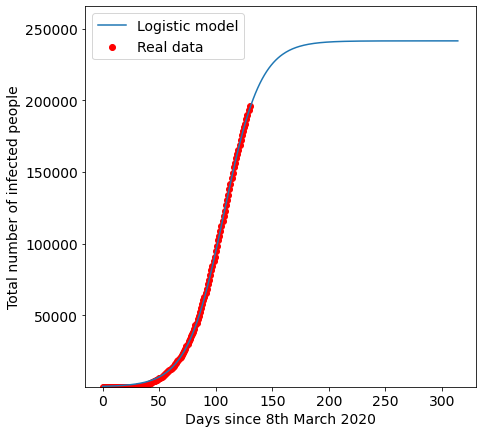

In [13]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
plt.legend()
plt.xlabel("Days since 8th March 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

# Evaluate the MSE error

Evaluating the mean squared error (MSE) is not very meaningful on its own until we can compare it with another predictive method. We can compare MSE of our regression with MSE from another method to check if our logistic regression model works better than the other predictive model. The model with the lower MSE performs better.




In [14]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2])
for i in x]

print('Mean squared error: ', mean_squared_error(y,y_pred_logistic))

Mean squared error:  994036.2433783162


# Epilogue

We should be mindful of some caveats:

* These predictions will only be meaningful when the peak has actually been crossed definitively. 

* Also, the reliability of the reported cases would also influence the dependability of the model. Developing countries, especially the South Asian countries have famously failed to report accurate disaster statisticcs in the past. 

* Also, the testing numbers are low overall, especially in cities outside Dhaka where the daily new cases still have not peaked yet.

* Since most of the cases reported were in Dhaka, the findings indicate that the peak in Dhaka may have been reached already.

* If there is a second outbreak before the first outbreak subsides, the curve may not be sigmoid shaped and hence the results may not be as meaningful.

* The total reported case numbers will possibly be greater than 238000, because the daily new cases is still rising in some cities other than Dhaka. It is not unsound to expect that the total reported case count for this first instance of Covid-19 outbreak could very well reach 300000 or more.

* The government recently hiked the prices of tests which may have led to increased unwillingness in suspected candidates to actually test for the disease, and that may have influenced the recent confirmed case counts.

# References

Inspiration for theory and code from the following articles:

* [Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

* [Logistic growth modelling of COVID-19 proliferation in China and its international implications](https://www.sciencedirect.com/science/article/pii/S1201971220303039)

* [Logistic Growth Model for COVID-19](https://www.wolframcloud.com/obj/covid-19/Published/Logistic-Growth-Model-for-COVID-19.nb)
